In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, entropy
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.stats import entropy as scipy_entropy
from sklearn.metrics import mean_squared_error
import numpy as np
from fastdtw import fastdtw

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the preprocessed EEG data
file_dir = 'Data'
x_path = os.path.join(file_dir, 'x.npy')
y_path = os.path.join(file_dir, 'y.npy')
X = np.load(x_path)
y = np.load(y_path)

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Create custom datasets and data loaders
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the client-side and server-side models for different split scenarios
class ClientModel1(nn.Module):
    def __init__(self):
        super(ClientModel1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        return x

class ServerModel1(nn.Module):
    def __init__(self):
        super(ServerModel1, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel2(nn.Module):
    def __init__(self):
        super(ClientModel2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        return x

class ServerModel2(nn.Module):
    def __init__(self):
        super(ServerModel2, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel3(nn.Module):
    def __init__(self):
        super(ClientModel3, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        return x

class ServerModel3(nn.Module):
    def __init__(self):
        super(ServerModel3, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel4(nn.Module):
    def __init__(self):
        super(ClientModel4, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        return x

class ServerModel4(nn.Module):
    def __init__(self):
        super(ServerModel4, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel5(nn.Module):
    def __init__(self):
        super(ClientModel5, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        return x

class ServerModel5(nn.Module):
    def __init__(self):
        super(ServerModel5, self).__init__()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [20]:
import numpy as np
from dtaidistance import dtw

def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())

    size_kb = total_size_bytes / 1024
    size_mb = size_kb / 1024
    size_gb = size_mb / 1024
    return size_kb



# Function to evaluate the model and calculate privacy metrics
def evaluate_model(client_model, server_model, dataloader, scenario):
    client_model.eval()
    server_model.eval()
    y_true = []
    y_pred = []
    cosine_similarities = []
    pearson_correlations = []
    spearman_correlations = []
    mutual_info_scores = []
    kl_divergences = []
    js_divergences = []
    euclidean_distances = []
    entropies = []
    dtw_distances = []
    reconstruction_errors = []


    with torch.no_grad():
        for data, target in dataloader:
            client_output = client_model(data)
            server_output = server_model(client_output)
            predictions = (torch.sigmoid(server_output) > 0.5).float().squeeze()
            y_true.extend(target.numpy())
            y_pred.extend(predictions.numpy())

            raw_signal = data.view(data.size(0), -1).numpy()
            intermediate_output = client_output.view(client_output.size(0), -1)
            intermediate_output = nn.functional.interpolate(intermediate_output.unsqueeze(1), size=raw_signal.shape[1], mode='linear', align_corners=False)
            intermediate_output = intermediate_output.squeeze(1).numpy()

            cosine_sim = cosine_similarity(raw_signal, intermediate_output).diagonal()
            cosine_similarities.extend(cosine_sim)

            pearson_corr = np.array([pearsonr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
            pearson_correlations.extend(pearson_corr)

            spearman_corr = np.array([spearmanr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
            spearman_correlations.extend(spearman_corr)

            mutual_info = np.array([mutual_info_score(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            mutual_info_scores.extend(mutual_info)

            kl_div = np.mean([entropy(raw_signal[i], intermediate_output[i] + 1e-10) for i in range(data.size(0))])  # Add a small epsilon to avoid division by zero
            kl_divergences.append(kl_div)
            
            js_div = np.mean([0.5 * (entropy(raw_signal[i], intermediate_output[i]) + entropy(intermediate_output[i], raw_signal[i])) for i in range(data.size(0))])
            js_divergences.append(js_div)

            euclidean_dist = np.mean([euclidean(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            euclidean_distances.append(euclidean_dist)

            # Calculate entropy of the raw signal and intermediate output
            raw_signal_entropy = np.array([scipy_entropy(raw_signal[i]) for i in range(data.size(0))])
            intermediate_output_entropy = np.array([scipy_entropy(intermediate_output[i]) for i in range(data.size(0))])
            entropies.extend(raw_signal_entropy - intermediate_output_entropy)

            # Calculate DTW distance between raw signal and intermediate output using fastdtw
            dtw_dist = np.mean([fastdtw(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
            dtw_distances.append(dtw_dist)


            # Calculate reconstruction error between raw signal and intermediate output
            reconstruction_error = np.mean([mean_squared_error(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            reconstruction_errors.append(reconstruction_error)
        
            # # Calculate DTW distance between raw signal and intermediate output
            # dtw_dist = np.mean([dtw.distance(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            # dtw_distances.append(dtw_dist)

    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    avg_cosine_similarity = np.mean(cosine_similarities)
    avg_pearson_correlation = np.mean(pearson_correlations)
    avg_spearman_correlation = np.mean(spearman_correlations)
    avg_mutual_info_score = np.mean(mutual_info_scores)
    avg_kl_divergence = np.mean(kl_divergences)
    avg_js_divergence = np.mean(js_divergences)
    avg_euclidean_distance = np.mean(euclidean_distances)
    # client_model_size = sum(p.numel() for p in client_model.parameters())
    client_model_size = get_model_size(client_model)
    avg_entropy_difference = np.mean(entropies)
    avg_dtw_distance = np.mean(dtw_distances)
    avg_reconstruction_error = np.mean(reconstruction_errors)


    # accuracy = accuracy_score(y_true, y_pred)
    # cm = confusion_matrix(y_true, y_pred)
    # client_model_size = get_model_size(client_model)


    print(f"Scenario {scenario}:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")
    print(f"Average Pearson Correlation: {avg_pearson_correlation:.4f}")
    print(f"Average Spearman Correlation: {avg_spearman_correlation:.4f}")
    print(f"Average Mutual Information Score: {avg_mutual_info_score:.4f}")
    print(f"Average KL Divergence: {avg_kl_divergence:.4f}")
    print(f"Average JS Divergence: {avg_js_divergence:.4f}")
    print(f"Average Euclidean Distance: {avg_euclidean_distance:.4f}")
    print(f"Average Entropy Difference: {avg_entropy_difference:.4f}")
    print(f"Average DTW Distance: {avg_dtw_distance:.4f}")
    print(f"Average Reconstruction Error: {avg_reconstruction_error:.4f}")

    print(f"Client Model Size: {client_model_size}")
    print()

    return {
        'accuracy': accuracy,
        'cosine_similarity': cosine_similarities,
        'pearson_correlation': pearson_correlations,
        'spearman_correlation': spearman_correlations,
        'mutual_info_score': mutual_info_scores,
        'kl_divergence': kl_divergences,
        'js_divergence': js_divergences,
        'euclidean_distance': euclidean_distances,
        'entropy_difference': entropies,
        'dtw_distance': dtw_distances,
        'reconstruction_error': reconstruction_errors,
        'client_model_size': client_model_size
    }

    

    # return accuracy, avg_cosine_similarity, avg_pearson_correlation, avg_spearman_correlation, avg_mutual_info_score, avg_kl_divergence, avg_js_divergence, avg_euclidean_distance, avg_entropy_difference, avg_dtw_distance, avg_reconstruction_error, client_model_size

# Train and evaluate the model for different split scenarios
scenarios = [
    (ClientModel1(), ServerModel1(), "Breaking at Conv1"),
    (ClientModel2(), ServerModel2(), "Breaking at Conv2"),
    (ClientModel3(), ServerModel3(), "Breaking at Conv3"),
    (ClientModel4(), ServerModel4(), "Breaking at Conv4"),
    (ClientModel5(), ServerModel5(), "Breaking at FC1"),
    # (EEGNet(), None, "No Split")
]

results = {}

for i, (client_model, server_model, scenario_name) in enumerate(scenarios):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list(client_model.parameters()) + (list(server_model.parameters()) if server_model else []), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        client_model.train()
        if server_model:
            server_model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_dataloader):
            client_output = client_model(data)
            if server_model:
                server_output = server_model(client_output)
                loss = criterion(server_output.squeeze(), target)
            else:
                loss = criterion(client_output.squeeze(), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        print(f"Scenario {i+1}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # print(f"\nEvaluation Results for Scenario {i+1}:")
    # accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, entropy_diff, model_size = evaluate_model(client_model, server_model, test_dataloader, i+1)
    # results.append((scenario_name, accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, entropy_diff, model_size))
    print(f"\nEvaluation Results for Scenario {i+1}:")
    # accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, entropy_diff, dtw_dist, reconstruction_error, model_size = evaluate_model(client_model, server_model, test_dataloader, i+1)
    # results.append((scenario_name, accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, entropy_diff, dtw_dist, reconstruction_error, model_size))
    scenario_results = evaluate_model(client_model, server_model, test_dataloader, i+1)
    results[i] = scenario_results



Scenario 1, Epoch [1/10], Train Loss: 0.9956
Scenario 1, Epoch [2/10], Train Loss: 0.4295
Scenario 1, Epoch [3/10], Train Loss: 0.3253
Scenario 1, Epoch [4/10], Train Loss: 0.2076
Scenario 1, Epoch [5/10], Train Loss: 0.1850
Scenario 1, Epoch [6/10], Train Loss: 0.1750
Scenario 1, Epoch [7/10], Train Loss: 0.0406
Scenario 1, Epoch [8/10], Train Loss: 0.0182
Scenario 1, Epoch [9/10], Train Loss: 0.0707
Scenario 1, Epoch [10/10], Train Loss: 0.0869

Evaluation Results for Scenario 1:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 1:
Test Accuracy: 0.8667
Confusion Matrix:
[[137  23]
 [  9  71]]
Average Cosine Similarity: -0.0087
Average Pearson Correlation: -0.0016
Average Spearman Correlation: -0.0018
Average Mutual Information Score: 3.8283
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 9031.7990
Average Entropy Difference: -inf
Average DTW Distance: 965402.9154
Average Reconstruction Error: 4069.3296
Client Model Size: 3.875

Scenario 2, Epoch [1/10], Train Loss: 0.8588
Scenario 2, Epoch [2/10], Train Loss: 0.3751
Scenario 2, Epoch [3/10], Train Loss: 0.2840
Scenario 2, Epoch [4/10], Train Loss: 0.1503
Scenario 2, Epoch [5/10], Train Loss: 0.0997
Scenario 2, Epoch [6/10], Train Loss: 0.0666
Scenario 2, Epoch [7/10], Train Loss: 0.0310
Scenario 2, Epoch [8/10], Train Loss: 0.1632
Scenario 2, Epoch [9/10], Train Loss: 0.0358
Scenario 2, Epoch [10/10], Train Loss: 0.1123

Evaluation Results for Scenario 2:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 2:
Test Accuracy: 0.9250
Confusion Matrix:
[[159   1]
 [ 17  63]]
Average Cosine Similarity: -0.0053
Average Pearson Correlation: -0.0007
Average Spearman Correlation: 0.0008
Average Mutual Information Score: 1.8691
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8554.2394
Average Entropy Difference: -inf
Average DTW Distance: 950721.2803
Average Reconstruction Error: 3648.3596
Client Model Size: 28.125

Scenario 3, Epoch [1/10], Train Loss: 1.0781
Scenario 3, Epoch [2/10], Train Loss: 0.4763
Scenario 3, Epoch [3/10], Train Loss: 0.3786
Scenario 3, Epoch [4/10], Train Loss: 0.3538
Scenario 3, Epoch [5/10], Train Loss: 0.2068
Scenario 3, Epoch [6/10], Train Loss: 0.1219
Scenario 3, Epoch [7/10], Train Loss: 0.1476
Scenario 3, Epoch [8/10], Train Loss: 0.0914
Scenario 3, Epoch [9/10], Train Loss: 0.0290
Scenario 3, Epoch [10/10], Train Loss: 0.0119

Evaluation Results for Scenario 3:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 3:
Test Accuracy: 0.9208
Confusion Matrix:
[[155   5]
 [ 14  66]]
Average Cosine Similarity: -0.0061
Average Pearson Correlation: -0.0014
Average Spearman Correlation: -0.0035
Average Mutual Information Score: 2.0152
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8525.0690
Average Entropy Difference: -inf
Average DTW Distance: 963699.3297
Average Reconstruction Error: 3621.4380
Client Model Size: 124.625

Scenario 4, Epoch [1/10], Train Loss: 2.2323
Scenario 4, Epoch [2/10], Train Loss: 0.4367
Scenario 4, Epoch [3/10], Train Loss: 0.3520
Scenario 4, Epoch [4/10], Train Loss: 0.2830
Scenario 4, Epoch [5/10], Train Loss: 0.2203
Scenario 4, Epoch [6/10], Train Loss: 0.1041
Scenario 4, Epoch [7/10], Train Loss: 0.1756
Scenario 4, Epoch [8/10], Train Loss: 0.1258
Scenario 4, Epoch [9/10], Train Loss: 0.0498
Scenario 4, Epoch [10/10], Train Loss: 0.0211

Evaluation Results for Scenario 4:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 4:
Test Accuracy: 0.8917
Confusion Matrix:
[[149  11]
 [ 15  65]]
Average Cosine Similarity: -0.0020
Average Pearson Correlation: -0.0001
Average Spearman Correlation: 0.0003
Average Mutual Information Score: 0.2852
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8517.7161
Average Entropy Difference: -inf
Average DTW Distance: 969259.3023
Average Reconstruction Error: 3615.0825
Client Model Size: 509.625

Scenario 5, Epoch [1/10], Train Loss: 1.5132
Scenario 5, Epoch [2/10], Train Loss: 0.3851
Scenario 5, Epoch [3/10], Train Loss: 0.2834
Scenario 5, Epoch [4/10], Train Loss: 0.2337
Scenario 5, Epoch [5/10], Train Loss: 0.1003
Scenario 5, Epoch [6/10], Train Loss: 0.2472
Scenario 5, Epoch [7/10], Train Loss: 0.1138
Scenario 5, Epoch [8/10], Train Loss: 0.0587
Scenario 5, Epoch [9/10], Train Loss: 0.0279
Scenario 5, Epoch [10/10], Train Loss: 0.0101

Evaluation Results for Scenario 5:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 5:
Test Accuracy: 0.9000
Confusion Matrix:
[[160   0]
 [ 24  56]]
Average Cosine Similarity: -0.0126
Average Pearson Correlation: -0.0067
Average Spearman Correlation: -0.0050
Average Mutual Information Score: 2.8512
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8701.9621
Average Entropy Difference: -inf
Average DTW Distance: 960661.7802
Average Reconstruction Error: 3763.7583
Client Model Size: 20990.125



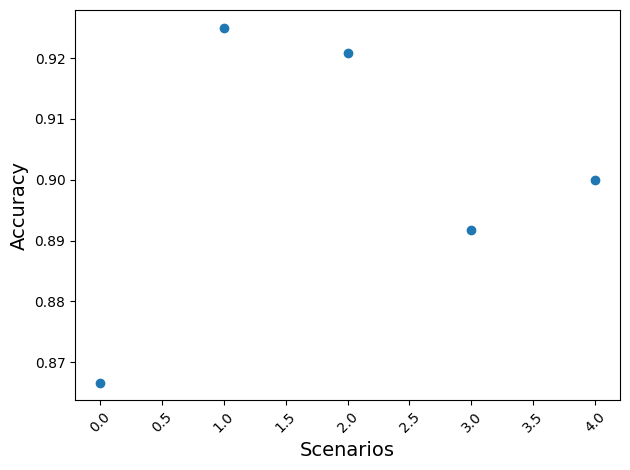

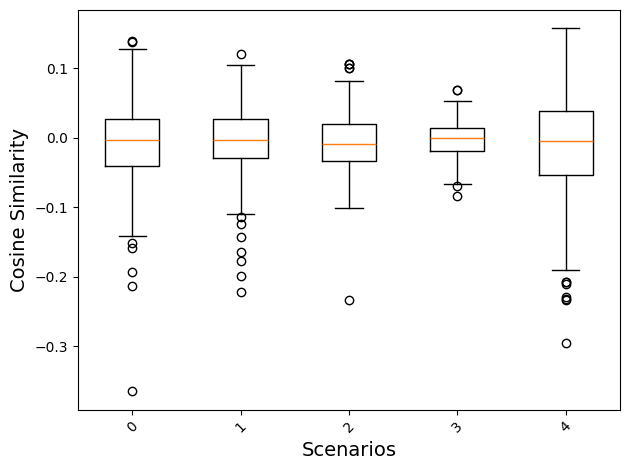

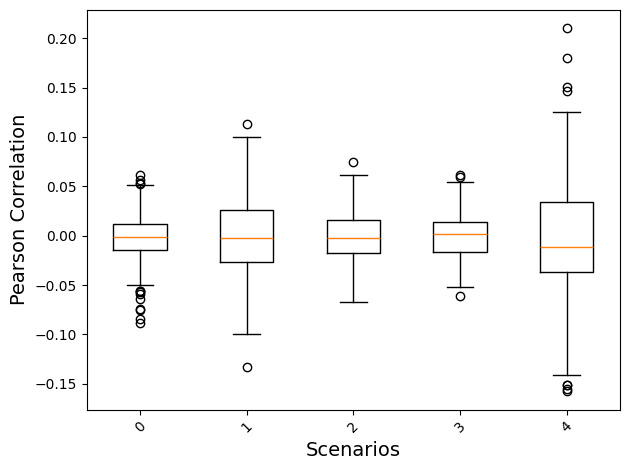

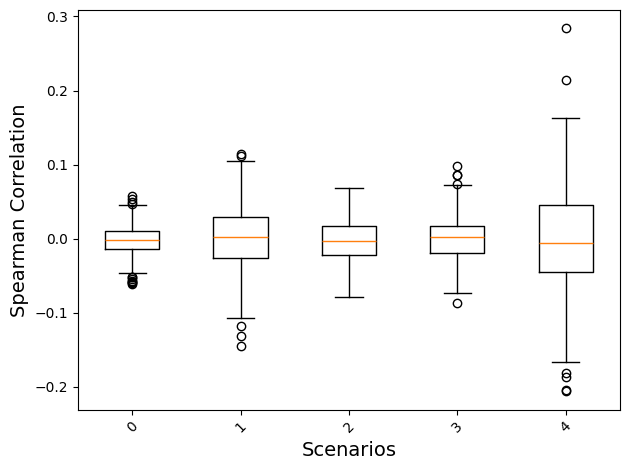

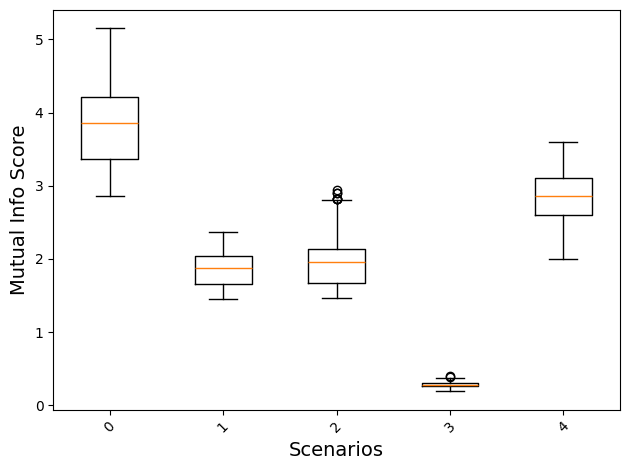

/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


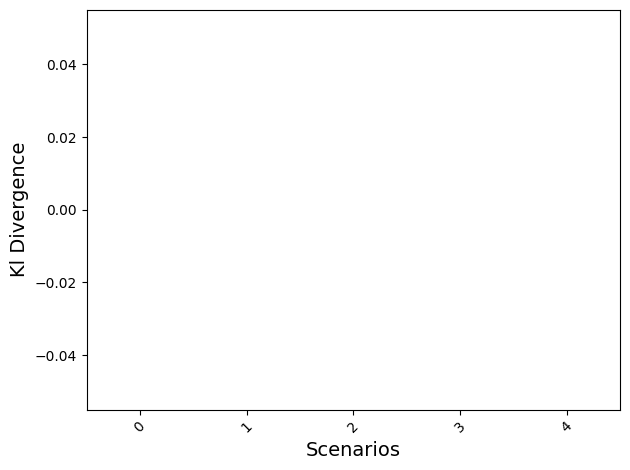

/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


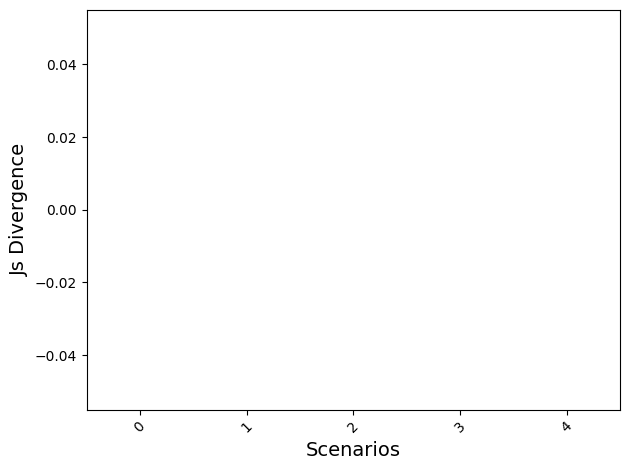

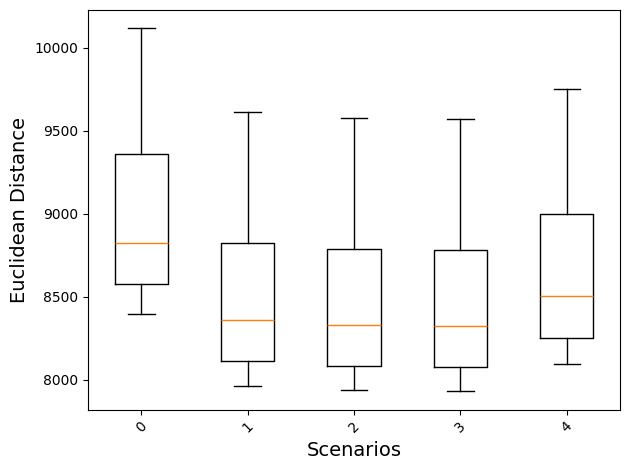

/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


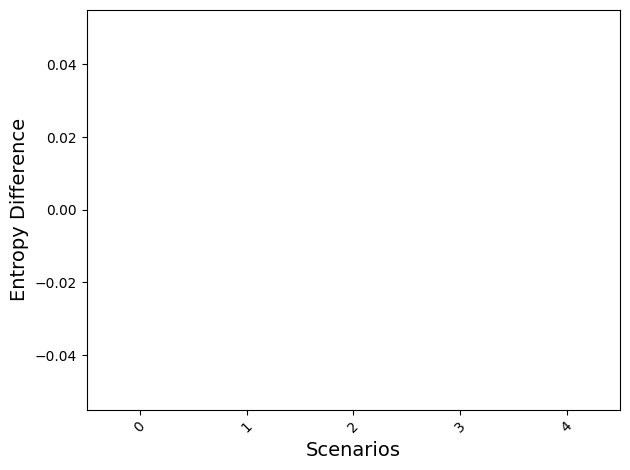

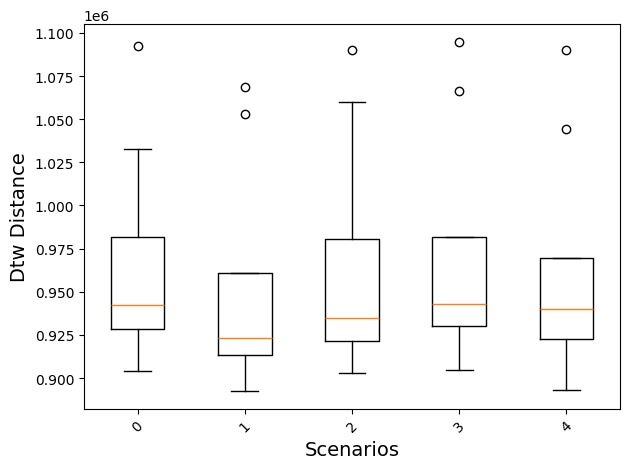

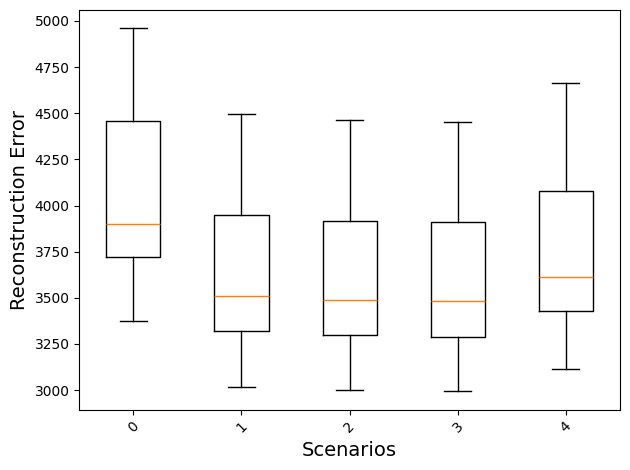

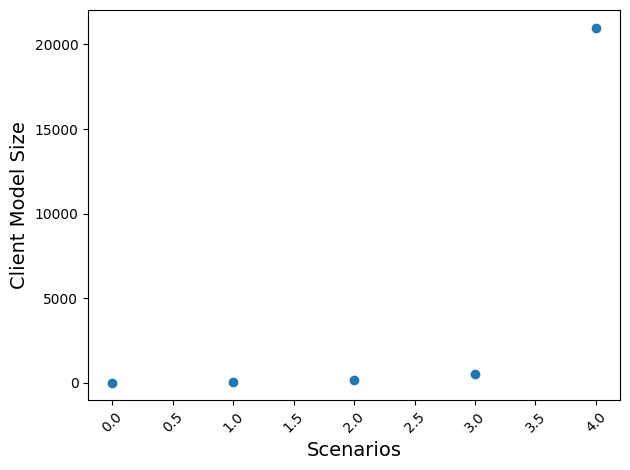

In [83]:
scenarios = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'FC1']


metrics = ['accuracy', 'cosine_similarity', 'pearson_correlation', 'spearman_correlation', 'mutual_info_score', 'kl_divergence', 'js_divergence', 'euclidean_distance', 'entropy_difference', 'dtw_distance', 'reconstruction_error', 'client_model_size']
# metrics = [ 'cosine_similarity', 'pearson_correlation', 'spearman_correlation', 'mutual_info_score',  'dtw_distance', 'reconstruction_error']
i = 1
for metric in metrics:
    # plt.subplot(, i)
    data = [results[scenario][metric] for scenario in results.keys()]
    labels = list(results.keys())
    
    if metric == 'accuracy' or metric == 'client_model_size':
    # Scatterplot for accuracy and client model size
        plt.scatter(labels, [d for d in data])
    else:
        # Box plot for other metrics
        plt.boxplot(data, labels=labels)
    i=i+1
    
    
    plt.xlabel("Scenarios", fontsize=14)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=14)
    # plt.title(f'{metric.replace("_", " ").title()} vs Scenario')
    plt.xticks(rotation=45)
    plt.savefig(f'{i}')

    plt.tight_layout()
    plt.show()
    




cosine_similarity
pearson_correlation
spearman_correlation
mutual_info_score
dtw_distance
reconstruction_error


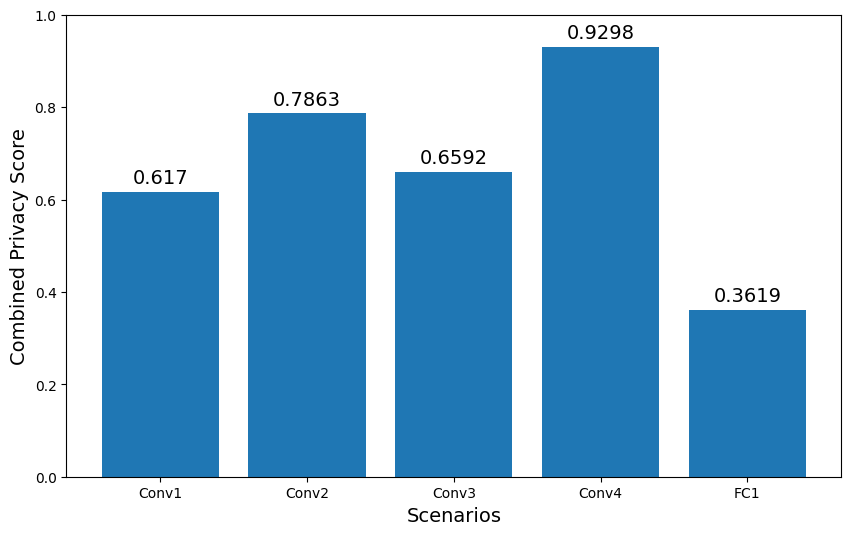

In [82]:
metrics = [ 'cosine_similarity', 'pearson_correlation', 'spearman_correlation', 'mutual_info_score',  'dtw_distance', 'reconstruction_error']
cs = []
pc = []
sc = [] 
mi = []
dtw =[]
re = []
all_metrics = [cs, pc, sc, mi, dtw, re]
j = 0
for metric in metrics:
    print (metric)
    data = [results[scenario][metric] for scenario in results.keys()]
    # print(len(data), len(data[0]))
    labels = list(results.keys())
    all_metrics[j] = data
    j+=1
    # cs.append(data)
    # pc.append(data)
    # sc.append(data)
    # mi.append(data)
    # dtw.append(data)
    # re.append(data)
    
cosine_similarity = []   
pearson_correlation = []
spearman_correlation = []
mutual_information = []
dtw_distance = []
reconstruction_error = []



for i in range(5):
    cosine_similarity.append(np.mean(all_metrics[0][i]))

for i in range(5):
    pearson_correlation.append(np.mean(all_metrics[1][i]))

for i in range(5):
    spearman_correlation.append(np.mean(all_metrics[2][i]))

for i in range(5):
    mutual_information.append(np.mean(all_metrics[3][i]))

for i in range(5):
    dtw_distance.append(np.mean(all_metrics[4][i]))


for i in range(5):
    reconstruction_error.append(np.mean(all_metrics[5][i]))


# all_metrics = [cs, pc, sc, mi dtw, re]
# for i in all_metrics:


import matplotlib.pyplot as plt
import numpy as np

scenarios = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'FC1']

# Normalize the metrics (higher is better for distances, lower is better for correlations and mutual information)
# For correlations, we take the absolute value as we want them to be close to zero
pearson_normalized = 1 - np.abs(pearson_correlation) / np.max(np.abs(pearson_correlation))
spearman_normalized = 1 - np.abs(spearman_correlation) / np.max(np.abs(spearman_correlation))
mutual_information_normalized = 1 - mutual_information / np.max(mutual_information)
cosine_normalized = 1 - np.abs(cosine_similarity) / np.max(np.abs(cosine_similarity))
euclidean_normalized = reconstruction_error / np.max(reconstruction_error)
dtw_normalized = dtw_distance / np.max(dtw_distance)

# Combine the normalized scores into a single privacy score
combined_privacy_score = (pearson_normalized + spearman_normalized + mutual_information_normalized +
                          cosine_normalized + euclidean_normalized + dtw_normalized) / 6

# Plot the combined privacy score
plt.figure(figsize=(10, 6))
# plt.bar(scenarios, combined_privacy_score)
bars = plt.bar(scenarios, combined_privacy_score)

# Annotate the bars with the combined privacy score values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom', fontsize=14)


   
plt.xlabel('Scenarios', fontsize=14)
plt.ylabel('Combined Privacy Score', fontsize=14)
# plt.title('Combined Privacy Score Across Different Scenarios')
plt.ylim(0, 1)
plt.show()
    
    

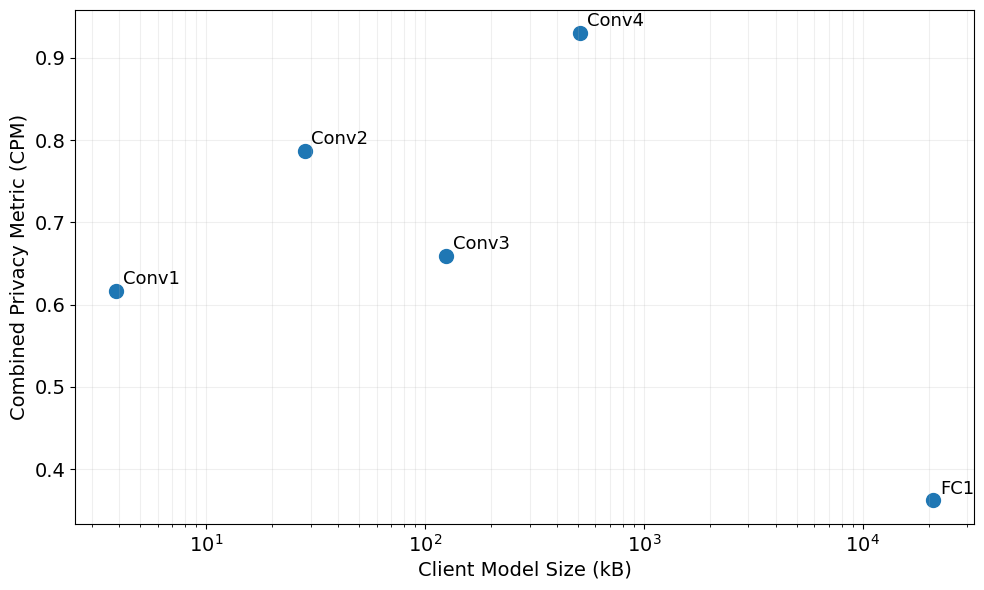

In [8]:
import matplotlib.pyplot as plt

# CPM values from the image
cpm_values = [0.617, 0.7863, 0.6592, 0.9298, 0.3619]

# Client model sizes
client_model_sizes = [3.875, 28.125, 124.625, 509.625, 20990.125]

# Scenarios
scenarios = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'FC1']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(client_model_sizes, cpm_values, s=100)

# Customize the plot
plt.xscale('log')  # Use log scale for x-axis due to large range of model sizes
plt.xlabel('Client Model Size (kB)', fontsize=14)
plt.ylabel('Combined Privacy Metric (CPM)', fontsize=14)
# plt.title('Privacy-Efficiency Trade-off', fontsize=16)

# Annotate points with scenario names
for i, scenario in enumerate(scenarios):
    plt.annotate(scenario, (client_model_sizes[i], cpm_values[i]), xytext=(5,5), 
                 textcoords='offset points', fontsize=13)

# # Find the optimal point (highest CPM with smallest model size)
# optimal_index = cpm_values.index(max(cpm_values[:2]))  # Consider only Conv1 and Conv2
# plt.annotate('Optimal', (client_model_sizes[optimal_index], cpm_values[optimal_index]), 
#              xytext=(10, 10), textcoords='offset points', fontsize=12, 
#              arrowprops=dict(arrowstyle="->", color='red'))

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('privacy-efficiency')
plt.tight_layout()
plt.show()


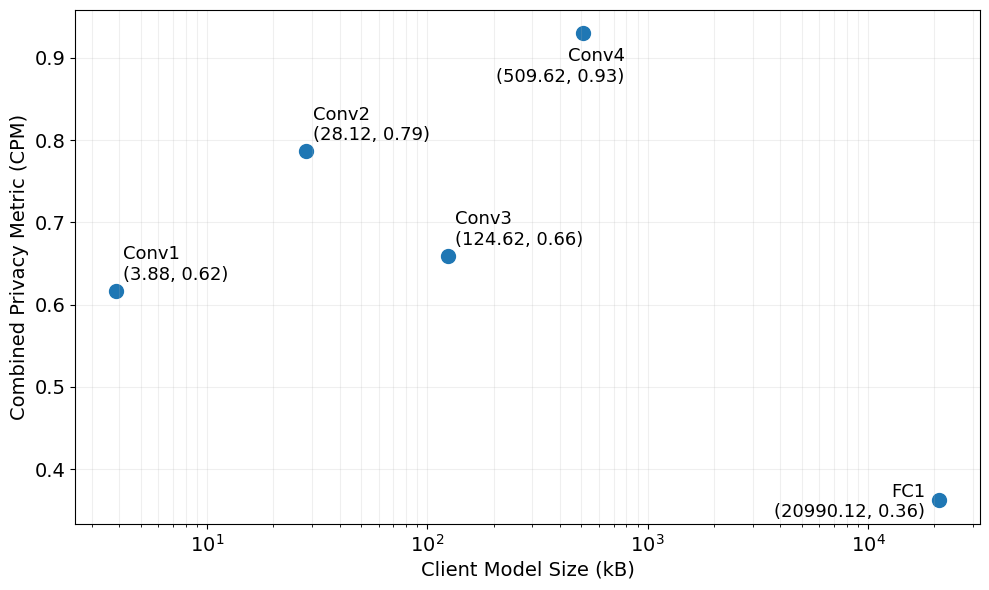

In [26]:
import matplotlib.pyplot as plt

# CPM values from the image
cpm_values = [0.617, 0.7863, 0.6592, 0.9298, 0.3619]
# Client model sizes
client_model_sizes = [3.875, 28.125, 124.625, 509.625, 20990.125]
# Scenarios
scenarios = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'FC1']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(client_model_sizes, cpm_values, s=100)

# Customize the plot
plt.xscale('log')  # Use log scale for x-axis due to large range of model sizes
plt.xlabel('Client Model Size (kB)', fontsize=14)
plt.ylabel('Combined Privacy Metric (CPM)', fontsize=14)

# Annotate points with scenario names and values
for i, scenario in enumerate(scenarios):
    if scenario == 'Conv4':
        xytext = (30, -38)
        ha = 'right'
    elif scenario == 'FC1':
        xytext = (-10, -15)
        ha = 'right'
    else:
        xytext = (5, 5)
        ha = 'left'
    
    plt.annotate(f"{scenario}\n({client_model_sizes[i]:.2f}, {cpm_values[i]:.2f})", 
                 (client_model_sizes[i], cpm_values[i]), 
                 xytext=xytext, 
                 textcoords='offset points', 
                 fontsize=13,
                 ha=ha,
                 va='bottom')

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('privacy-efficiency2')
plt.tight_layout()
plt.show()

In [ ]:
##Visualize Results

In [21]:
# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = EEGNet()

In [34]:
##Model Summary

In [33]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 80, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Transpose to (batch_size, channels, seq_len)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = EEGNet()

# Print the model summary
summary(model, input_size=( 1280, 10))  # Ensure input_size matches (channels, seq_len)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1280]             992
         MaxPool1d-2              [-1, 32, 640]               0
            Conv1d-3              [-1, 64, 640]           6,208
         MaxPool1d-4              [-1, 64, 320]               0
            Conv1d-5             [-1, 128, 320]          24,704
         MaxPool1d-6             [-1, 128, 160]               0
            Conv1d-7             [-1, 256, 160]          98,560
         MaxPool1d-8              [-1, 256, 80]               0
            Linear-9                  [-1, 128]       2,621,568
           Linear-10                   [-1, 64]           8,256
           Linear-11                    [-1, 1]              65
Total params: 2,760,353
Trainable params: 2,760,353
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forw

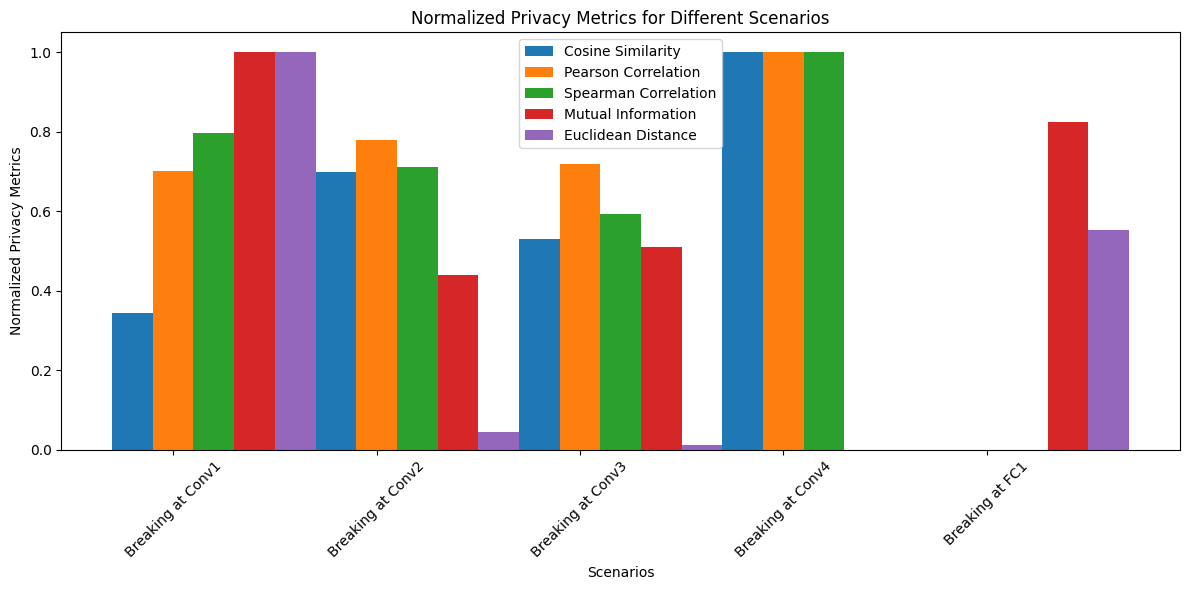

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data
scenarios = ['Breaking at Conv1', 'Breaking at Conv2', 'Breaking at Conv3', 'Breaking at Conv4', 'Breaking at FC1']
cosine_similarity = [-0.0080, -0.0046, -0.0062, -0.0017, -0.0113]
pearson_correlation = [-0.0012, -0.0008, -0.0011, 0.0003, -0.0047]
spearman_correlation = [-0.0007, -0.0013, -0.0021, 0.0007, -0.0062]
mutual_information = [3.8176, 1.8446, 2.0979, 0.3012, 3.2019]
euclidean_distance = [9055.0683, 8540.5522, 8523.5747, 8517.0102, 8814.8080]

# Normalize the data
cosine_similarity_norm = (cosine_similarity - np.min(cosine_similarity)) / (np.max(cosine_similarity) - np.min(cosine_similarity))
pearson_correlation_norm = (pearson_correlation - np.min(pearson_correlation)) / (np.max(pearson_correlation) - np.min(pearson_correlation))
spearman_correlation_norm = (spearman_correlation - np.min(spearman_correlation)) / (np.max(spearman_correlation) - np.min(spearman_correlation))
mutual_information_norm = (mutual_information - np.min(mutual_information)) / (np.max(mutual_information) - np.min(mutual_information))
euclidean_distance_norm = (euclidean_distance - np.min(euclidean_distance)) / (np.max(euclidean_distance) - np.min(euclidean_distance))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting each normalized metric
ax.bar([i - 0.2 for i in range(len(scenarios))], cosine_similarity_norm, width=0.2, label='Cosine Similarity')
ax.bar([i for i in range(len(scenarios))], pearson_correlation_norm, width=0.2, label='Pearson Correlation')
ax.bar([i + 0.2 for i in range(len(scenarios))], spearman_correlation_norm, width=0.2, label='Spearman Correlation')
ax.bar([i + 0.4 for i in range(len(scenarios))], mutual_information_norm, width=0.2, label='Mutual Information')
ax.bar([i + 0.6 for i in range(len(scenarios))], euclidean_distance_norm, width=0.2, label='Euclidean Distance')

# Adding labels and title
ax.set_xlabel('Scenarios')
ax.set_ylabel('Normalized Privacy Metrics')
ax.set_title('Normalized Privacy Metrics for Different Scenarios')
ax.set_xticks(range(len(scenarios)))
ax.set_xticklabels(scenarios, rotation=45)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


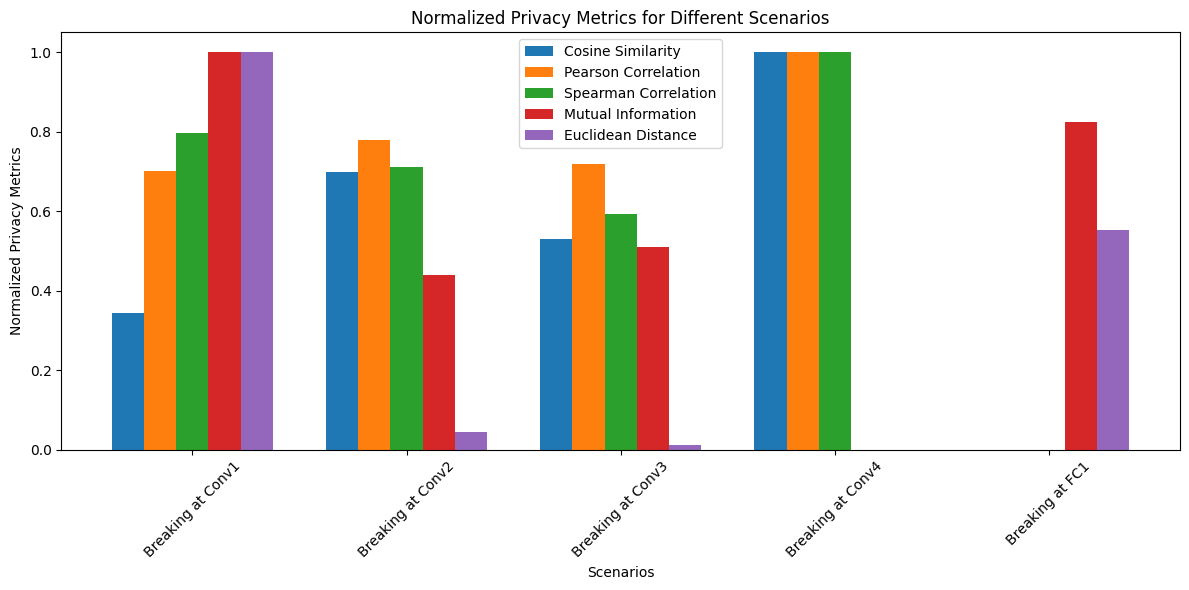

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Data
scenarios = ['Breaking at Conv1', 'Breaking at Conv2', 'Breaking at Conv3', 'Breaking at Conv4', 'Breaking at FC1']
cosine_similarity = [-0.0080, -0.0046, -0.0062, -0.0017, -0.0113]
pearson_correlation = [-0.0012, -0.0008, -0.0011, 0.0003, -0.0047]
spearman_correlation = [-0.0007, -0.0013, -0.0021, 0.0007, -0.0062]
mutual_information = [3.8176, 1.8446, 2.0979, 0.3012, 3.2019]
euclidean_distance = [9055.0683, 8540.5522, 8523.5747, 8517.0102, 8814.8080]

# Normalize the data
cosine_similarity_norm = (cosine_similarity - np.min(cosine_similarity)) / (np.max(cosine_similarity) - np.min(cosine_similarity))
pearson_correlation_norm = (pearson_correlation - np.min(pearson_correlation)) / (np.max(pearson_correlation) - np.min(pearson_correlation))
spearman_correlation_norm = (spearman_correlation - np.min(spearman_correlation)) / (np.max(spearman_correlation) - np.min(spearman_correlation))
mutual_information_norm = (mutual_information - np.min(mutual_information)) / (np.max(mutual_information) - np.min(mutual_information))
euclidean_distance_norm = (euclidean_distance - np.min(euclidean_distance)) / (np.max(euclidean_distance) - np.min(euclidean_distance))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Width of each bar
bar_width = 0.15

# Plotting each normalized metric with adjusted x-coordinates
ax.bar(np.arange(len(scenarios)) - 2 * bar_width, cosine_similarity_norm, width=bar_width, label='Cosine Similarity')
ax.bar(np.arange(len(scenarios)) - bar_width, pearson_correlation_norm, width=bar_width, label='Pearson Correlation')
ax.bar(np.arange(len(scenarios)), spearman_correlation_norm, width=bar_width, label='Spearman Correlation')
ax.bar(np.arange(len(scenarios)) + bar_width, mutual_information_norm, width=bar_width, label='Mutual Information')
ax.bar(np.arange(len(scenarios)) + 2 * bar_width, euclidean_distance_norm, width=bar_width, label='Euclidean Distance')

# Adding labels and title
ax.set_xlabel('Scenarios')
ax.set_ylabel('Normalized Privacy Metrics')
ax.set_title('Normalized Privacy Metrics for Different Scenarios')
ax.set_xticks(np.arange(len(scenarios)))
ax.set_xticklabels(scenarios, rotation=45)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


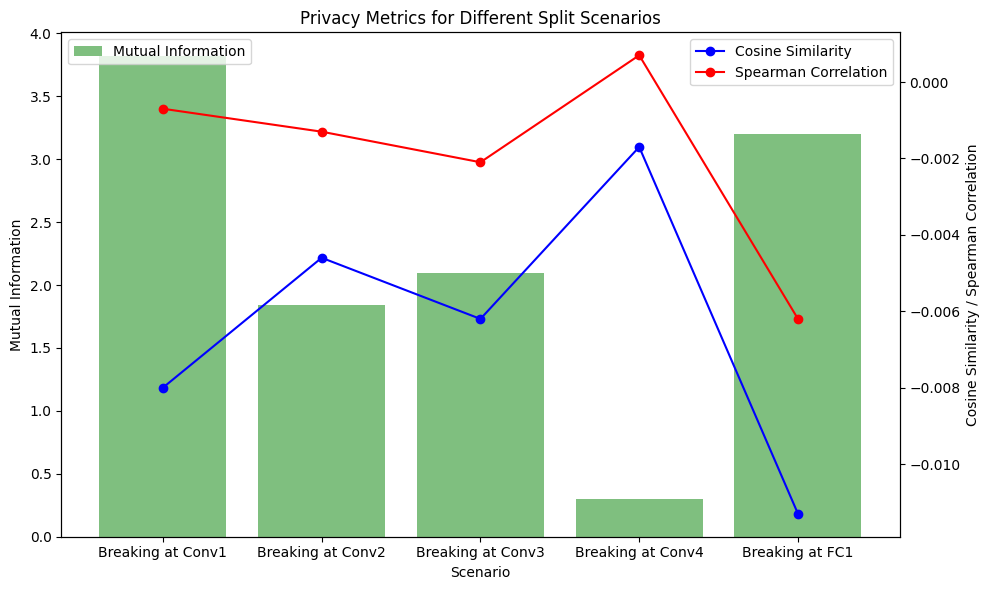

In [46]:
import matplotlib.pyplot as plt

# Data
scenarios = ['Breaking at Conv1', 'Breaking at Conv2', 'Breaking at Conv3', 'Breaking at Conv4', 'Breaking at FC1']
cosine_similarity = [-0.0080, -0.0046, -0.0062, -0.0017, -0.0113]
spearman_correlation = [-0.0007, -0.0013, -0.0021, 0.0007, -0.0062]
mutual_information = [3.8176, 1.8446, 2.0979, 0.3012, 3.2019]

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Mutual Information using a bar plot
ax1.bar(scenarios, mutual_information, color='g', alpha=0.5, label='Mutual Information')

# Create a secondary y-axis for Cosine Similarity and Spearman Correlation using line plots
ax2 = ax1.twinx()
ax2.plot(scenarios, cosine_similarity, color='b', marker='o', label='Cosine Similarity')
ax2.plot(scenarios, spearman_correlation, color='r', marker='o', label='Spearman Correlation')

# Set axis labels and legend
ax1.set_ylabel('Mutual Information')
ax2.set_ylabel('Cosine Similarity / Spearman Correlation')
ax1.set_xlabel('Scenario')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title
plt.title('Privacy Metrics for Different Split Scenarios')

# Show plot
plt.tight_layout()
plt.show()


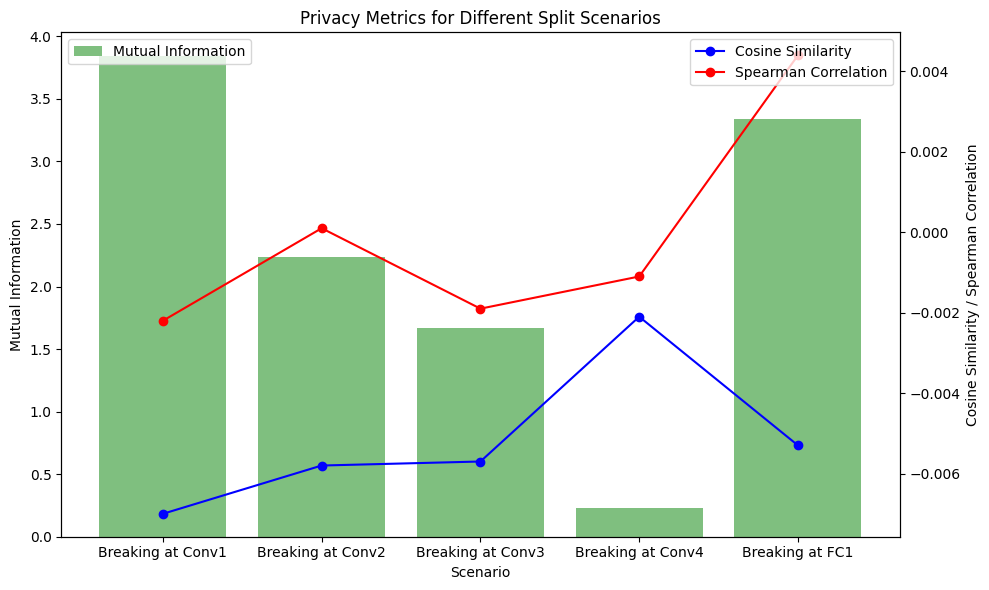

In [60]:
import matplotlib.pyplot as plt

# Data
scenarios = ['Breaking at Conv1', 'Breaking at Conv2', 'Breaking at Conv3', 'Breaking at Conv4', 'Breaking at FC1']
cosine_similarity = [-0.0070,
-0.0058,
-0.0057,
-0.0021,
-0.0053]
spearman_correlation = [-0.0022,
0.0001,
-0.0019,
-0.0011,
0.0044 ]
mutual_information = [3.84,
2.24,
1.67,
0.23,
3.34]

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Mutual Information using a bar plot
ax1.bar(scenarios, mutual_information, color='g', alpha=0.5, label='Mutual Information')

# Create a secondary y-axis for Cosine Similarity and Spearman Correlation using line plots
ax2 = ax1.twinx()
ax2.plot(scenarios, cosine_similarity, color='b', marker='o', label='Cosine Similarity')
ax2.plot(scenarios, spearman_correlation, color='r', marker='o', label='Spearman Correlation')

# Set axis labels and legend
ax1.set_ylabel('Mutual Information')
ax2.set_ylabel('Cosine Similarity / Spearman Correlation')
ax1.set_xlabel('Scenario')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title
plt.title('Privacy Metrics for Different Split Scenarios')

# Show plot
plt.tight_layout()
plt.show()


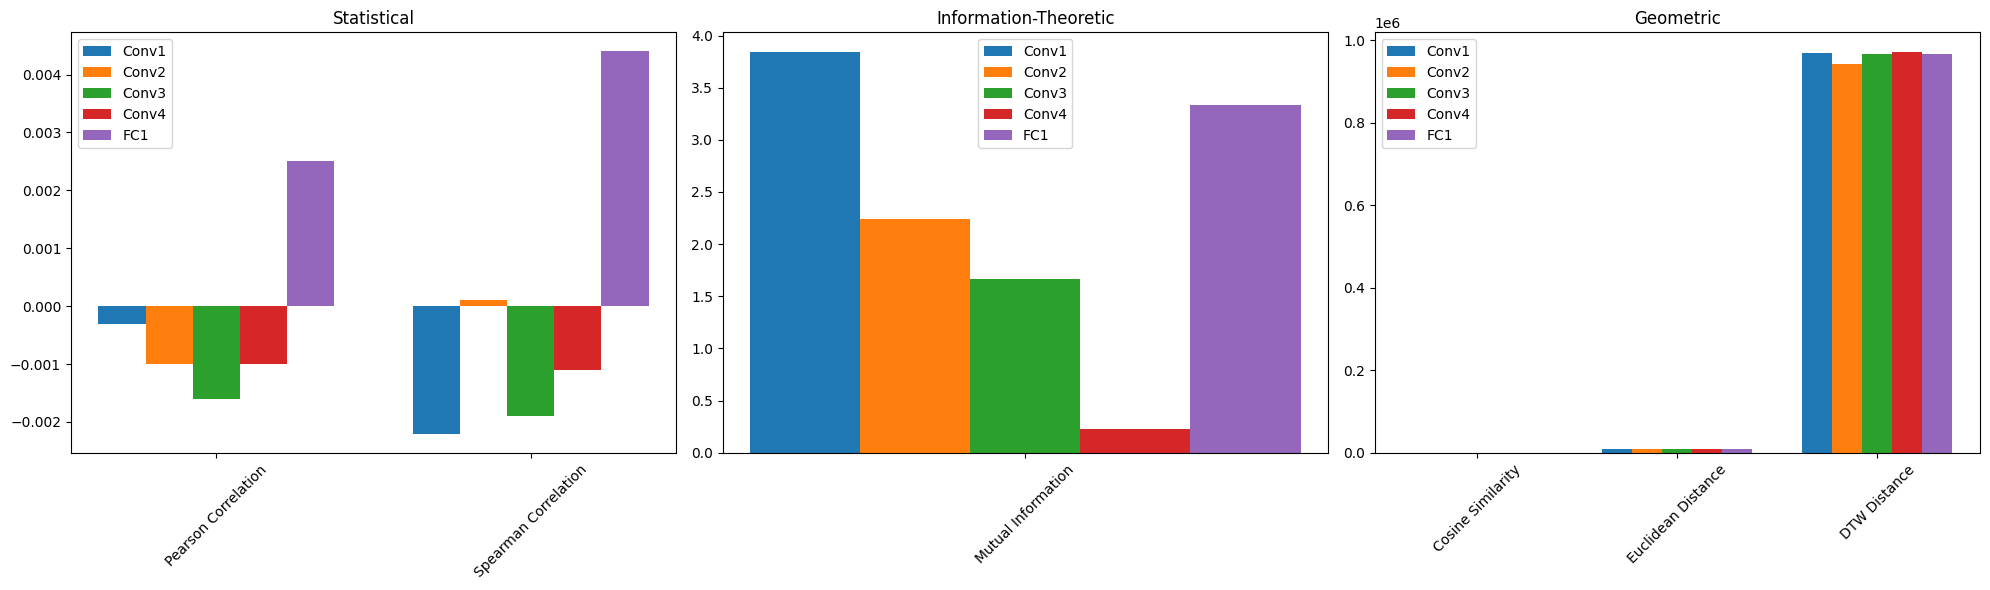

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Privacy metric values for each breaking point
conv1 = [-0.0003, -0.0022, 3.8395, -0.0070, 9070.0681, 968043.3972]
conv2 = [-0.0010, 0.0001, 2.2395, -0.0058, 8553.1258, 941524.4162]
conv3 = [-0.0016, -0.0019, 1.6687, -0.0057, 8522.7265, 966600.4249]
conv4 = [-0.0010, -0.0011, 0.2306, -0.0021, 8517.3554, 970658.5830]
fc1 = [0.0025, 0.0044, 3.3381, -0.0053, 8719.1358, 966105.4495]

# Metric categories and names
categories = ['Statistical', 'Information-Theoretic', 'Geometric']
metrics = ['Pearson Correlation', 'Spearman Correlation', 'Mutual Information',
           'Cosine Similarity', 'Euclidean Distance', 'DTW Distance']

# Create subplots for each metric category
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, category in enumerate(categories):
    ax = axs[i]
    start_idx = sum([2, 1, 3][:i])
    end_idx = start_idx + [2, 1, 3][i]
    
    x = np.arange(end_idx - start_idx)
    width = 0.15
    
    ax.bar(x - 2*width, [conv1[j] for j in range(start_idx, end_idx)], width, label='Conv1')
    ax.bar(x - width, [conv2[j] for j in range(start_idx, end_idx)], width, label='Conv2')
    ax.bar(x, [conv3[j] for j in range(start_idx, end_idx)], width, label='Conv3')
    ax.bar(x + width, [conv4[j] for j in range(start_idx, end_idx)], width, label='Conv4')
    ax.bar(x + 2*width, [fc1[j] for j in range(start_idx, end_idx)], width, label='FC1')
    
    ax.set_title(category)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics[start_idx:end_idx])
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

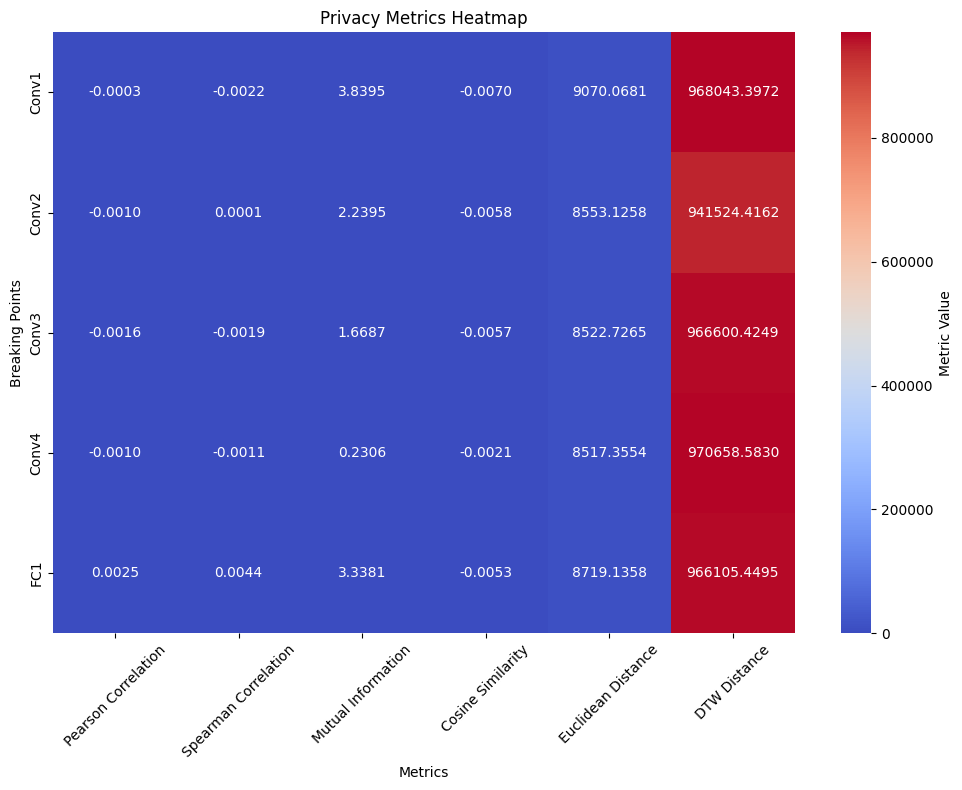

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Privacy metric values for each breaking point
conv1 = [-0.0003, -0.0022, 3.8395, -0.0070, 9070.0681, 968043.3972]
conv2 = [-0.0010, 0.0001, 2.2395, -0.0058, 8553.1258, 941524.4162]
conv3 = [-0.0016, -0.0019, 1.6687, -0.0057, 8522.7265, 966600.4249]
conv4 = [-0.0010, -0.0011, 0.2306, -0.0021, 8517.3554, 970658.5830]
fc1 = [0.0025, 0.0044, 3.3381, -0.0053, 8719.1358, 966105.4495]

# Metric names
metrics = ['Pearson Correlation', 'Spearman Correlation', 'Mutual Information',
           'Cosine Similarity', 'Euclidean Distance', 'DTW Distance']

# Create a DataFrame for the heatmap
data = [conv1, conv2, conv3, conv4, fc1]
df = pd.DataFrame(data, columns=metrics, index=['Conv1', 'Conv2', 'Conv3', 'Conv4', 'FC1'])

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.4f', cbar_kws={'label': 'Metric Value'})
plt.title('Privacy Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Breaking Points')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

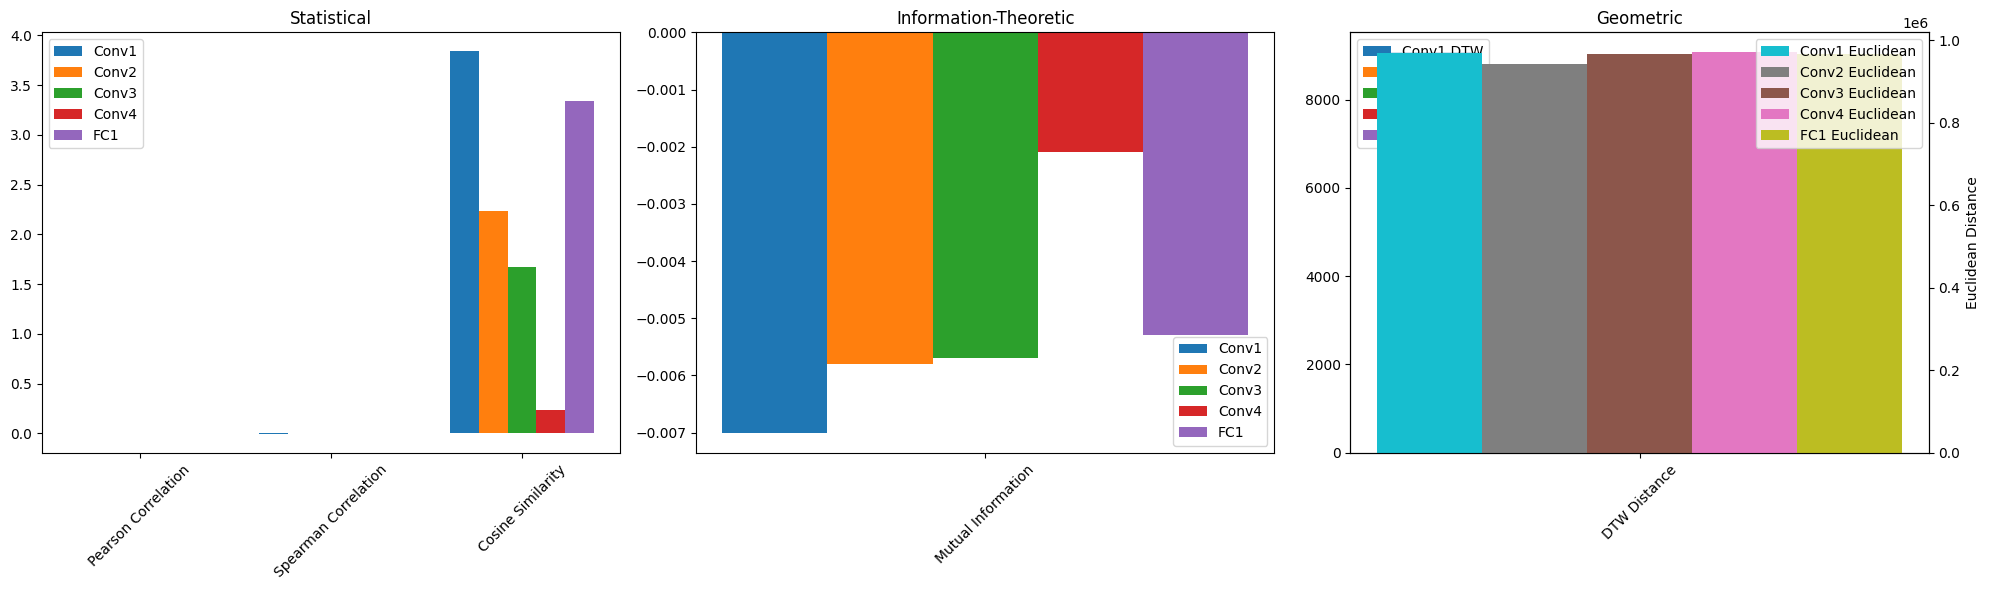

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Privacy metric values for each breaking point
conv1 = [-0.0003, -0.0022, 3.8395, -0.0070, 9070.0681, 968043.3972]
conv2 = [-0.0010, 0.0001, 2.2395, -0.0058, 8553.1258, 941524.4162]
conv3 = [-0.0016, -0.0019, 1.6687, -0.0057, 8522.7265, 966600.4249]
conv4 = [-0.0010, -0.0011, 0.2306, -0.0021, 8517.3554, 970658.5830]
fc1 = [0.0025, 0.0044, 3.3381, -0.0053, 8719.1358, 966105.4495]

# Metric categories and names
categories = ['Statistical', 'Information-Theoretic', 'Geometric']
metrics = ['Pearson Correlation', 'Spearman Correlation', 'Cosine Similarity',
           'Mutual Information', 'DTW Distance', 'Euclidean Distance']

# Create subplots for each metric category
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot for the 'Statistical' category
ax = axs[0]
x = np.arange(3)  # 3 metrics in 'Statistical' category
width = 0.15

ax.bar(x - 2*width, conv1[:3], width, label='Conv1')
ax.bar(x - width, conv2[:3], width, label='Conv2')
ax.bar(x, conv3[:3], width, label='Conv3')
ax.bar(x + width, conv4[:3], width, label='Conv4')
ax.bar(x + 2*width, fc1[:3], width, label='FC1')

ax.set_title('Statistical')
ax.set_xticks(x)
ax.set_xticklabels(metrics[:3])
ax.tick_params(axis='x', rotation=45)
ax.legend()

# Plot for the 'Information-Theoretic' category
ax = axs[1]
x = np.arange(1)  # 1 metric in 'Information-Theoretic' category
width = 0.15

ax.bar(x - 2*width, conv1[3:4], width, label='Conv1')
ax.bar(x - width, conv2[3:4], width, label='Conv2')
ax.bar(x, conv3[3:4], width, label='Conv3')
ax.bar(x + width, conv4[3:4], width, label='Conv4')
ax.bar(x + 2*width, fc1[3:4], width, label='FC1')

ax.set_title('Information-Theoretic')
ax.set_xticks(x)
ax.set_xticklabels(metrics[3:4])
ax.tick_params(axis='x', rotation=45)
ax.legend()

# Plot for the 'Geometric' category with two y-axes
ax1 = axs[2]
x = np.arange(1)  # 1 metric in 'Geometric' category
width = 0.15

ax1.bar(x - 2*width, conv1[4:5], width, label='Conv1 DTW', color='tab:blue')
ax1.bar(x - width, conv2[4:5], width, label='Conv2 DTW', color='tab:orange')
ax1.bar(x, conv3[4:5], width, label='Conv3 DTW', color='tab:green')
ax1.bar(x + width, conv4[4:5], width, label='Conv4 DTW', color='tab:red')
ax1.bar(x + 2*width, fc1[4:5], width, label='FC1 DTW', color='tab:purple')

ax1.set_title('Geometric')
ax1.set_xticks(x)
ax1.set_xticklabels(['DTW Distance'])
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for Euclidean Distance
ax2 = ax1.twinx()
ax2.bar(x - 2*width, conv1[5:], width, label='Conv1 Euclidean', color='tab:cyan')
ax2.bar(x - width, conv2[5:], width, label='Conv2 Euclidean', color='tab:gray')
ax2.bar(x, conv3[5:], width, label='Conv3 Euclidean', color='tab:brown')
ax2.bar(x + width, conv4[5:], width, label='Conv4 Euclidean', color='tab:pink')
ax2.bar(x + 2*width, fc1[5:], width, label='FC1 Euclidean', color='tab:olive')

ax2.set_ylabel('Euclidean Distance')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_1006/2626126541.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(scenarios,  ha='right')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_1006/2626126541.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(scenarios,  ha='right')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_1006/2626126541.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 2].set_xticklabels(scenarios,  ha='right')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_1006/2626126541.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

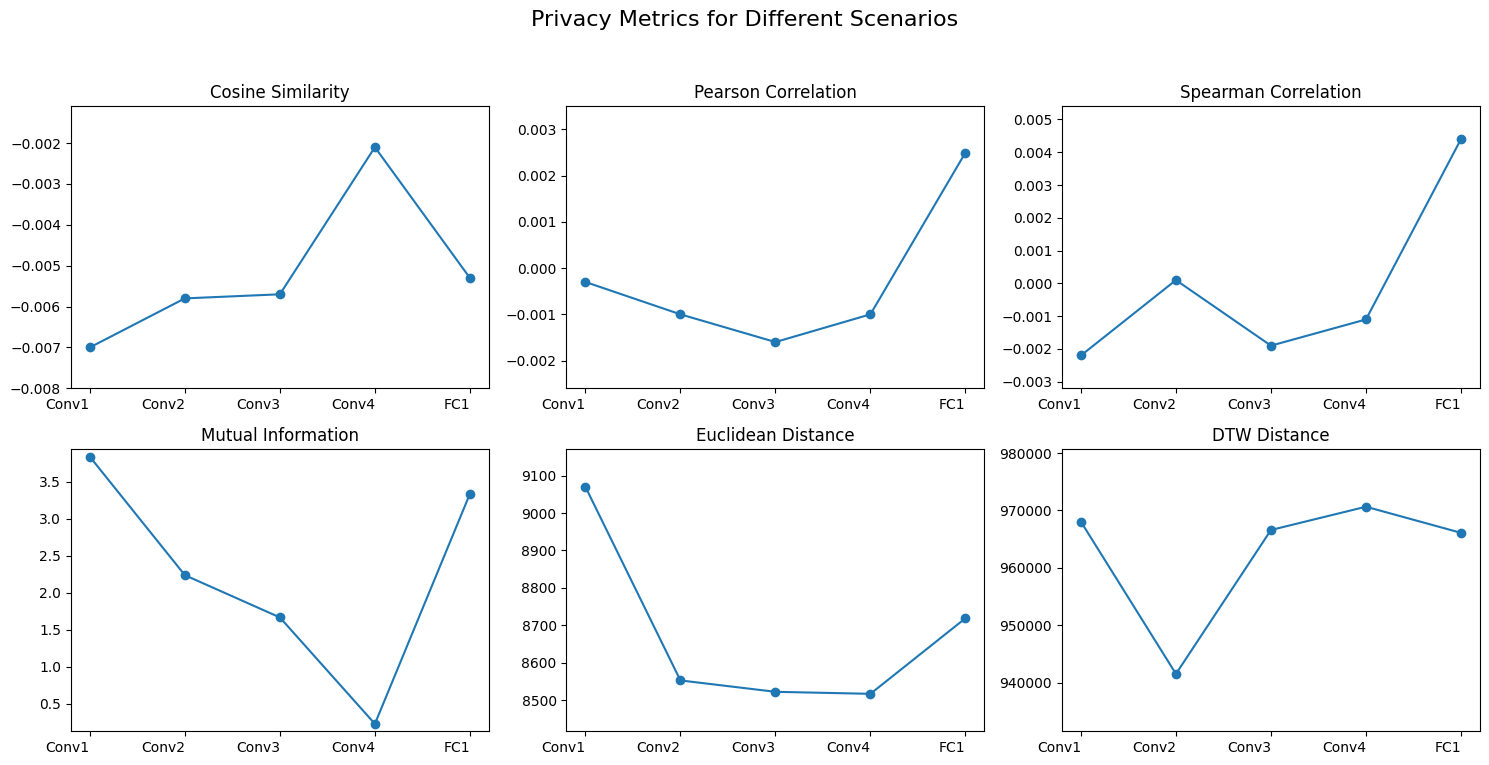

In [70]:
import matplotlib.pyplot as plt

# Privacy metrics data
scenarios = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'FC1']
cosine_similarity = [-0.0070, -0.0058, -0.0057, -0.0021, -0.0053]
pearson_correlation = [-0.0003, -0.0010, -0.0016, -0.0010, 0.0025]
spearman_correlation = [-0.0022, 0.0001, -0.0019, -0.0011, 0.0044]
mutual_information = [3.8395, 2.2395, 1.6687, 0.2306, 3.3381]
euclidean_distance = [9070.0681, 8553.1258, 8522.7265, 8517.3554, 8719.1358]
dtw_distance = [968043.3972, 941524.4162, 966600.4249, 970658.5830, 966105.4495]

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Privacy Metrics for Different Scenarios', fontsize=16)

# Cosine Similarity
axs[0, 0].plot(scenarios, cosine_similarity, marker='o')
axs[0, 0].set_title('Cosine Similarity')
axs[0, 0].set_xticklabels(scenarios,  ha='right')
axs[0, 0].set_ylim(min(cosine_similarity) - 0.001, max(cosine_similarity) + 0.001)

# Pearson Correlation
axs[0, 1].plot(scenarios, pearson_correlation, marker='o')
axs[0, 1].set_title('Pearson Correlation')
axs[0, 1].set_xticklabels(scenarios,  ha='right')
axs[0, 1].set_ylim(min(pearson_correlation) - 0.001, max(pearson_correlation) + 0.001)

# Spearman Correlation
axs[0, 2].plot(scenarios, spearman_correlation, marker='o')
axs[0, 2].set_title('Spearman Correlation')
axs[0, 2].set_xticklabels(scenarios,  ha='right')
axs[0, 2].set_ylim(min(spearman_correlation) - 0.001, max(spearman_correlation) + 0.001)

# Mutual Information
axs[1, 0].plot(scenarios, mutual_information, marker='o')
axs[1, 0].set_title('Mutual Information')
axs[1, 0].set_xticklabels(scenarios,  ha='right')
axs[1, 0].set_ylim(min(mutual_information) - 0.1, max(mutual_information) + 0.1)

# Euclidean Distance
axs[1, 1].plot(scenarios, euclidean_distance, marker='o')
axs[1, 1].set_title('Euclidean Distance')
axs[1, 1].set_xticklabels(scenarios, ha='right')
axs[1, 1].set_ylim(min(euclidean_distance) - 100, max(euclidean_distance) + 100)

# DTW Distance
axs[1, 2].plot(scenarios, dtw_distance, marker='o')
axs[1, 2].set_title('DTW Distance')
axs[1, 2].set_xticklabels(scenarios,  ha='right')
axs[1, 2].set_ylim(min(dtw_distance) - 10000, max(dtw_distance) + 10000)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plots
plt.show()